In [8]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from sympy.solvers.solveset import linsolve
import itertools as it
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from scipy.optimize import *
from numpy import *

#STEP 1: Set the parameter values, state space and the transition matrix.
#PARAMETERS
β=0.95
δ=0.025
γ=5
α=0.36
L = [0.91, 0.93]
z=[0.95, 1.05]
e=[0,1]
Γ=1.5

#State space
k0=np.arange(0,5,0.2)
k1=np.arange(5.3,50,0.6)
k=np.concatenate((k0,k1))
K=np.arange(16,18.5,0.5)

#TRANSITION MATRIX
π_11, π_12, π_13, π_14, π_21, π_22, π_23, π_24, π_31, π_32, π_33, π_34, π_41, π_42, π_43, π_44 = symbols ('π_11, π_12, π_13, π_14, π_21, π_22, π_23, π_24, π_31, π_32, π_33, π_34, π_41, π_42, π_43, π_44')
Π_1=linsolve([π_11 + π_12 + π_13 + π_14 -1, 
          π_21 + π_22 + π_23 + π_24 -1, 
          π_31 + π_32 + π_33 + π_34 -1, 
          π_41 + π_42 + π_43 + π_44 -1,
          π_21 + π_22 - 7/8,
          π_23 + π_24 - 1/8,
          π_43 + π_44 - 7/8,
          π_41 + π_42 - 1/8,
          π_33 + π_34 - 7/8,
          π_11 + π_12 - 7/8,
          π_31 + π_32 - 1/8,  
          π_13 + π_14 - 1/8,
          (0.04/(1/8))*π_31 + (0.96/(1/8))*π_41 - 0.1, 
          (0.04/(7/8))*π_33 + (0.96/(7/8))*π_43 - 0.04,
          (0.1/(7/8))*π_11 + (0.9/(7/8))*π_21 - 0.1,
          (0.1/(1/8))*π_13 + (0.9/(1/8))*π_23 - 0.1,
          π_31 - (1.25/7)*π_11,
          π_13 - (0.75/7)*π_33,
          π_43-0.005,
          π_21-0.02],
          (π_11, π_12, π_13, π_14, π_21, π_22, π_23, π_24, π_31, π_32, π_33, π_34, π_41, π_42, π_43, π_44))


Π_1= np.asarray(list(Π_1))
Π_1= np.reshape(Π_1, (4,4))


# STEP 2: PERCEIVED LAW OF MOTION
#Law of Motion functions
def H(Z,i):
    """It takes a specific value of aggregate capital 
    and productivity shock and returns the log of the 
    next period aggregate capital."""
    b0g=0.1839
    b1g=0.9375
    b0b=0.3217
    b1b=0.8855
    return np.exp((b0g+b1g*np.log(Z))*i + ((b0b+b1b*np.log(Z))*(1-i)))
       
#Feasible consumption for all possible combinations of states. 
#Checking how itertools works.
#list(it.product(range(2), range(2),range(5)))

C=np.empty((100,100,5,2,2))    
for i,j,I,m,p in it.product(range(100), range(100),range(5), range(2), range(2)):
    def Implicit(x):
        c=x[0]
        F=empty((1))
        F[0] = pow(((1-α)*z[p]*pow((K[I]/L[m]),α))*e[m], (1+γ/γ))*pow(Γ*c, -1/γ) + (1+(α*z[p]*pow((L[m]/K[I]),(1-α))))*k[i] - k[j] -c
        return F

    C[i,j,I,m,p]=fsolve(Implicit,1)

In [9]:
#Compute wages and rent
w = np.empty((2,5))
r= np.empty((2,5))
for m,I in it.product(range(2), range(5)): 
    w[m,I] = (1-α)*z[m]*pow((K[I]/L[m]),α)
    r[m,I]= α*z[m]*pow((L[m]/K[I]),(1-α))

#Utility for consumption 
logC= np.log(C)

#Checing if there are undefined values for utility in consumption
np.isnan(logC)
logC[np.isnan(logC)]=0

#Compute Disutility from Labour
U_L = np.empty((100,100,5,2,2)) 
#Computing disutility from labour
for I,m in it.product(range(5),range(2)):
    U_L[:,:,I,m,:] = (Γ/(1+γ))*pow((w[m,I]/Γ*C[:,:,I,m,:]), (1+γ)/γ)
U_L

#Total Utility 
U= logC - U_L

In [10]:
#Value Function Iteration
V0g=np.zeros((100,5))
V1g=np.zeros((100,5))
V0b=np.zeros((100,5))
V1b=np.zeros((100,5))

V0gt=np.zeros((100,5))
V1gt=np.zeros((100,5))
V0bt=np.zeros((100,5))
V1bt=np.zeros((100,5))
count = 0
eps=0.00001
Dev=1
while Dev > eps: 
    for i,I in it.product(range(100), range(5)):
        j=np.argmin(abs(K - H(K[I],0)))
        V0bt[i,j]=max(U[i, :, j, 0, 0] + β*(((Π_1[0,0]*V0b[:,j]))+
                               (Π_1[0,1]*V1b[:,j])+(Π_1[0,2]*V0g[:,j])+(Π_1[0,3]*V1g[:,j])))

        V1bt[i,j]=max(U[i,:,j,1,0] + β*(((Π_1[1,0]*V0b[:,j]))+
                               (Π_1[1,1]*V1b[:,j])+(Π_1[1,2]*V0g[:,j])+(Π_1[1,3]*V1g[:,j])))

        f=np.argmin(abs(K - H(K[I],1)))
        V0gt[i,j]= max(U[i,:,f,0,1] + β*(((Π_1[2,0]*V0b[:,f]))+ (Π_1[2,1]*V1b[:,f])+(Π_1[2,2]*V0g[:,f])+(Π_1[2,3]*V1g[:,f])))
        V1gt[i,j] = max(U[i,:,f,1,1] + β*(((Π_1[3,0]*V0b[:,f]))+(Π_1[3,1]*V1b[:,f])+(Π_1[3,2]*V0g[:,f])+(Π_1[3,3]*V1g[:,f])))
        
        V0g=V0gt
        V1g=V1gt
        V0b=V0bt
        V1b=V1bt

        Diff0=abs(V0gt-V0g)
        dev0=Diff0.max()

        Diff1=abs(V1gt-V1g)
        dev1=Diff1.max()

        Diff2=abs(V0bt-V0b)
        dev2=Diff2.max()

        Diff3=abs(V1bt-V1b)
        dev3=Diff3.max()

        Dev=max(dev0, dev1, dev2, dev3)
        count+=1

In [12]:
#Retrieving Policy Functions
G0b=np.zeros((100,5))
G1b=np.zeros((100,5))
G0g=np.zeros((100,5))
G1g=np.zeros((100,5))
for i,I in it.product(range(100), range(5)):
    j=np.argmin(abs(K - H(K[I],0)))
    G0b[i,j]= np.argmax(U[i, :, j, 0, 0] + β*(((Π_1[0,0]*V0b[:,j]))+ (Π_1[0,1]*V1b[:,j])+(Π_1[0,2]*V0g[:,j])+(Π_1[0,3]*V1g[:,j])))
    G1b[i,j] = np.argmax(U[i,:,j,1,0] + β*(((Π_1[1,0]*V0b[:,j]))+(Π_1[1,1]*V1b[:,j])+(Π_1[1,2]*V0g[:,j])+(Π_1[1,3]*V1g[:,j])))

    f=np.argmin(abs(K - H(K[I],1)))
    G0g[i,j]=np.argmax(U[i,:,f,0,1] + β*(((Π_1[2,0]*V0b[:,f]))+
                           (Π_1[2,1]*V1b[:,f])+(Π_1[2,2]*V0g[:,f])+(Π_1[2,3]*V1g[:,f])))

    G1g[i,j]=np.argmax(U[i,:,f,1,1] + β*(((Π_1[3,0]*V0b[:,f]))+
                           (Π_1[3,1]*V1b[:,f])+(Π_1[3,2]*V0g[:,f])+(Π_1[3,3]*V1g[:,f])))

In [13]:
#Now, recover the values
g0g=np.zeros((100,5))
g1g=np.zeros((100,5))
g0b=np.zeros((100,5))
g1b=np.zeros((100,5))
for i,I in it.product(range(100), range(5)):
    g0g[i,I]=k[int(G0g[i,I])]
    g1g[i,I]=k[int(G1g[i,I])]
    g1b[i,I]=k[int(G1b[i,I])]
    g0b[i,I]=k[int(G0b[i,I])]

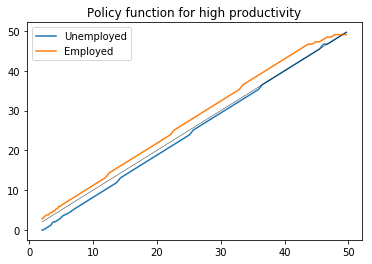

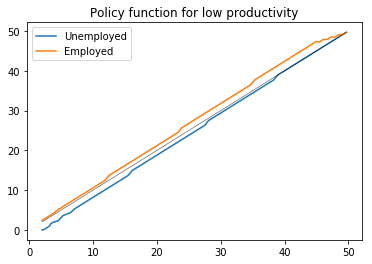

In [16]:
#Plot the policy functions for K=4
plt.plot(k[10:100],g0g[10:100,2], label='Unemployed')
plt.plot(k[10:100],g1g[10:100,2], label='Employed')
plt.plot(k[10:100],k[10:100], 'k', linewidth=0.4)
plt.legend()
plt.title('Policy function for high productivity')
plt.show()

plt.plot(k[10:100],g0b[10:100,2], label='Unemployed')
plt.plot(k[10:100],g1b[10:100,2], label='Employed')
plt.plot(k[10:100],k[10:100], 'k', linewidth=0.4)
plt.title('Policy function for low productivity')
plt.legend()
plt.show()